# Minimum Permutations Analysis with Unique Edge Sampling

This notebook implements a progressive training approach to determine the minimum number of permutations needed for effective edge probability distribution learning. It uses unique edge sampling to eliminate data leakage and maximize the benefit of multiple permutations.

In [33]:
# Standard library imports
import sys
import json
import time
import numpy as np
import pandas as pd
from pathlib import Path
from typing import Dict, List, Tuple, Any, Optional
import warnings
warnings.filterwarnings('ignore')

# Scientific computing
import scipy.sparse as sp
from scipy.stats import wasserstein_distance, ks_2samp
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, VotingRegressor
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import roc_auc_score, average_precision_score, log_loss, mean_squared_error, mean_absolute_error, r2_score
from sklearn.neural_network import MLPClassifier

# PyTorch for neural networks
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Add src to path
repo_dir = Path.cwd().parent
sys.path.append(str(repo_dir / 'src'))

# Import custom modules
from models import EdgePredictionNN
from data_processing import prepare_edge_prediction_data
from training import train_edge_prediction_model
from sampling import representative_negative_sampling, create_representative_dataset

print("All imports successful!")
print(f"Repository directory: {repo_dir}")
print(f"PyTorch available: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

All imports successful!
Repository directory: /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability
PyTorch available: 2.6.0
CUDA available: False


## Compare Model, Oracle, and Random MAE

This cell will compute and print the MAE for your model, the oracle (degree-pair mean), and the random/constant baseline on your validation set.

In [ ]:
# --- Compute and print MAE comparisons ---
from collections import defaultdict
import numpy as np
from sklearn.metrics import mean_absolute_error

# Ensure val_features and val_targets are 2D and 1D arrays, respectively
print('val_features shape:', val_features.shape)
print('val_targets shape:', val_targets.shape)

# Oracle MAE (degree-pair mean)
def compute_oracle_mae(val_features, val_targets):
    degpair_to_targets = defaultdict(list)
    for feat, target in zip(val_features, val_targets):
        key = (feat[0], feat[1])
        degpair_to_targets[key].append(target)
    degpair_to_mean = {k: np.mean(v) for k, v in degpair_to_targets.items()}
    oracle_preds = np.array([degpair_to_mean[(feat[0], feat[1])] for feat in val_features])
    oracle_mae = mean_absolute_error(val_targets, oracle_preds)
    return oracle_mae, oracle_preds

# Random/constant baseline MAE
def compute_random_mae(val_targets):
    mean_val = np.mean(val_targets)
    random_preds = np.full_like(val_targets, mean_val)
    random_mae = mean_absolute_error(val_targets, random_preds)
    return random_mae, random_preds

oracle_mae, oracle_preds = compute_oracle_mae(val_features, val_targets)
random_mae, random_preds = compute_random_mae(val_targets)

# Model MAE
try:
    model_preds = trainer.predict_probabilities(val_features)
    model_mae = mean_absolute_error(val_targets, model_preds)
    print(f"Model MAE:   {model_mae:.4f}")
except Exception as e:
    print("Could not compute model MAE:", e)
    model_mae = None

print(f"Oracle MAE:  {oracle_mae:.4f}")
print(f"Random MAE:  {random_mae:.4f}")

if model_mae is not None:
    print("\nMAE Comparison:")
    print(f"  Model:   {model_mae:.4f}")
    print(f"  Oracle:  {oracle_mae:.4f}")
    print(f"  Random:  {random_mae:.4f}")

In [34]:
# Configuration - OPTION 1: BASIC 2D MODEL (Source + Target Degrees Only)
CONFIG = {
    'edge_type': 'CtD',  # Compound-treats-Disease
    'max_permutations': 20,  # INCREASED - More training data for better convergence
    'validation_networks': 3,  # Number of held-out networks for validation
    'convergence_threshold': 0.2,  # REALISTIC - Based on achieved performance (~0.55 MAE)
    'n_bins': 8,  # INCREASED slightly - Better granularity while maintaining statistics
    'negative_sampling_ratio': 0.5,  # Standard ratio for balanced training
    'random_seed': 42,
    'model_types': ['NN', 'RF'],  # FOCUSED - Best performing models only
    'use_normalized_features': False,  # BASIC 2D MODEL - Source and target degrees only
    'use_regression_approach': True,
    'use_distribution_loss': True,  # NEW - Direct distribution-based training
    'use_adaptive_binning': True,   # NEW - Adaptive binning based on data density
    'use_ensemble_methods': True,   # NEW - Ensemble of specialized models
    'early_stopping_patience': 3,   # NEW - Stop early if no improvement
    'relative_improvement_threshold': 0.02,  # NEW - 2% improvement required
    'use_relative_convergence': True  # NEW - Use relative improvement criteria
}

# Set random seeds for reproducibility
np.random.seed(CONFIG['random_seed'])
torch.manual_seed(CONFIG['random_seed'])

# Directory setup
data_dir = repo_dir / 'data'
permutations_dir = data_dir / 'permutations'
downloads_dir = data_dir / 'downloads'
models_dir = repo_dir / 'models'
output_dir = repo_dir / 'results' / 'minimum_permutations_basic_2d'

# Create output directory
output_dir.mkdir(parents=True, exist_ok=True)

print("Configuration - BASIC 2D MODEL (Source + Target Degrees Only):")
for key, value in CONFIG.items():
    print(f"  {key}: {value}")
print(f"\n🎯 BASIC 2D MODEL CONFIGURATION:")
print(f"  - FEATURES: Only source_degree + target_degree (2 dimensions)")
print(f"  - NO log transforms, degree products, sums, or ratios")
print(f"  - SIMPLIFIED model to study pure degree effects")
print(f"  - convergence_threshold: {CONFIG['convergence_threshold']}")
print(f"  - negative_sampling_ratio: {CONFIG['negative_sampling_ratio']}")
print(f"  - model_types: {CONFIG['model_types']}")
print(f"\n🚀 EXPECTED OUTCOME:")
print(f"  - Focus: Pure effects of source and target node degrees")
print(f"  - Feature interpretability: Direct degree relationships")
print(f"  - Simplified neural network architecture for 2D input")
print(f"  - Clear understanding of degree-based edge prediction")
print(f"\nDirectories:")
print(f"  Data: {data_dir}")
print(f"  Permutations: {permutations_dir}")
print(f"  Downloads: {downloads_dir}")
print(f"  Output: {output_dir}")

Configuration - BASIC 2D MODEL (Source + Target Degrees Only):
  edge_type: CtD
  max_permutations: 20
  validation_networks: 3
  convergence_threshold: 0.2
  n_bins: 8
  negative_sampling_ratio: 0.5
  random_seed: 42
  model_types: ['NN', 'RF']
  use_normalized_features: False
  use_regression_approach: True
  use_distribution_loss: True
  use_adaptive_binning: True
  use_ensemble_methods: True
  early_stopping_patience: 3
  relative_improvement_threshold: 0.02
  use_relative_convergence: True

🎯 BASIC 2D MODEL CONFIGURATION:
  - FEATURES: Only source_degree + target_degree (2 dimensions)
  - NO log transforms, degree products, sums, or ratios
  - SIMPLIFIED model to study pure degree effects
  - convergence_threshold: 0.2
  - negative_sampling_ratio: 0.5
  - model_types: ['NN', 'RF']

🚀 EXPECTED OUTCOME:
  - Focus: Pure effects of source and target node degrees
  - Feature interpretability: Direct degree relationships
  - Simplified neural network architecture for 2D input
  - Clear 

In [35]:
# Setup data directories and paths
print("Setting up data directories...")

# Original data directory (main hetionet data)
original_data_dir = data_dir  # Main data directory contains the original network

# Find available permutation directories
available_permutations = []
if permutations_dir.exists():
    for perm_dir in permutations_dir.iterdir():
        if perm_dir.is_dir() and perm_dir.name.endswith('.hetmat'):
            available_permutations.append(perm_dir)

# Sort permutations by name to ensure consistent ordering
permutations_dirs = sorted(available_permutations)

print(f"Original data directory: {original_data_dir}")
print(f"Permutations directory: {permutations_dir}")
print(f"Found {len(permutations_dirs)} permutation directories:")
for i, perm_dir in enumerate(permutations_dirs[:5]):  # Show first 5
    print(f"  {i+1}. {perm_dir.name}")
if len(permutations_dirs) > 5:
    print(f"  ... and {len(permutations_dirs) - 5} more")

# Validate we have enough permutations for the experiment
if len(permutations_dirs) < CONFIG['max_permutations']:
    print(f"⚠️  Warning: Only {len(permutations_dirs)} permutations available, but max_permutations = {CONFIG['max_permutations']}")
    print("   Will reuse permutations if needed.")
else:
    print(f"✅ Sufficient permutations available for experiment")

# Check if original data exists
original_edge_file = original_data_dir / 'edges' / f"{CONFIG['edge_type']}.sparse.npz"
if original_edge_file.exists():
    print(f"✅ Original edge data found: {original_edge_file}")
else:
    print(f"❌ Original edge data not found: {original_edge_file}")
    print("Available edge files:")
    if (original_data_dir / 'edges').exists():
        for edge_file in (original_data_dir / 'edges').iterdir():
            if edge_file.suffix == '.npz':
                print(f"  - {edge_file.name}")

print("\nDirectory setup complete!")

Setting up data directories...
Original data directory: /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/data
Permutations directory: /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/data/permutations
Found 51 permutation directories:
  1. 000.hetmat
  2. 001.hetmat
  3. 002.hetmat
  4. 003.hetmat
  5. 004.hetmat
  ... and 46 more
✅ Sufficient permutations available for experiment
✅ Original edge data found: /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/data/edges/CtD.sparse.npz

Directory setup complete!


In [36]:
def load_permutation_data(perm_dir: Path, edge_type: str) -> Tuple[sp.csr_matrix, np.ndarray, np.ndarray]:
    """
    Load edge matrix and node degrees from a permutation directory.
    
    Parameters:
    -----------
    perm_dir : Path
        Path to permutation directory (e.g., data/permutations/000.hetmat/)
    edge_type : str
        Edge type to load (e.g., 'CtD')
    
    Returns:
    --------
    edge_matrix : scipy.sparse.csr_matrix
        Sparse matrix of edges
    source_degrees : np.ndarray
        Degrees of source nodes
    target_degrees : np.ndarray
        Degrees of target nodes
    """
    # Load edge matrix
    edge_file = perm_dir / 'edges' / f'{edge_type}.sparse.npz'
    if not edge_file.exists():
        raise FileNotFoundError(f"Edge file not found: {edge_file}")
    
    edge_matrix = sp.load_npz(edge_file).astype(bool).tocsr()
    
    # Calculate degrees
    source_degrees = np.array(edge_matrix.sum(axis=1)).flatten()
    target_degrees = np.array(edge_matrix.sum(axis=0)).flatten()
    
    return edge_matrix, source_degrees, target_degrees


def get_available_permutations(permutations_dir: Path) -> List[str]:
    """Get list of available permutation directories."""
    perm_dirs = []
    for item in permutations_dir.iterdir():
        if item.is_dir() and item.name.endswith('.hetmat'):
            perm_dirs.append(item.name)
    return sorted(perm_dirs)


def extract_improved_edge_features_and_labels(edge_matrix: sp.csr_matrix, 
                                             source_degrees: np.ndarray, 
                                             target_degrees: np.ndarray,
                                             negative_ratio: float = 0.5,
                                             use_normalized_features: bool = True,
                                             use_regression: bool = True) -> Tuple[np.ndarray, np.ndarray]:
    """
    Extract improved features and labels for edge prediction with better handling of sparse data.
    
    Parameters:
    -----------
    edge_matrix : scipy.sparse.csr_matrix
        Sparse matrix of edges
    source_degrees : np.ndarray
        Degrees of source nodes
    target_degrees : np.ndarray
        Degrees of target nodes
    negative_ratio : float
        Ratio of negative to positive edges to generate
    use_normalized_features : bool
        Whether to use log-normalized degree features
    use_regression : bool
        Whether to use actual edge density as target (regression) vs binary (classification)
    
    Returns:
    --------
    features : np.ndarray
        Feature matrix with enhanced features
    targets : np.ndarray
        Target values (binary for classification, continuous for regression)
    """
    # Get positive edges
    pos_edges = list(zip(*edge_matrix.nonzero()))
    n_pos = len(pos_edges)
    
    # Generate negative edges using degree-aware sampling
    n_neg = int(n_pos * negative_ratio)
    neg_edges = []
    
    # Sample negatives with probability proportional to degree product (more realistic)
    n_source, n_target = edge_matrix.shape
    
    # Create degree-based sampling probabilities
    source_probs = (source_degrees + 1) / (source_degrees + 1).sum()
    target_probs = (target_degrees + 1) / (target_degrees + 1).sum()
    
    attempts = 0
    max_attempts = n_neg * 20
    
    while len(neg_edges) < n_neg and attempts < max_attempts:
        # Sample based on degree probabilities
        source = np.random.choice(n_source, p=source_probs)
        target = np.random.choice(n_target, p=target_probs)
        
        if edge_matrix[source, target] == 0:  # Non-existing edge
            neg_edges.append((source, target))
        
        attempts += 1
    
    # If we couldn't get enough negatives, fill with random
    while len(neg_edges) < n_neg:
        source = np.random.randint(0, n_source)
        target = np.random.randint(0, n_target)
        if edge_matrix[source, target] == 0:
            neg_edges.append((source, target))
    
    # Create features and labels
    all_edges = pos_edges + neg_edges
    n_total = len(all_edges)
    
    # Enhanced feature set
    n_features = 6 if use_normalized_features else 2
    n_features =
    features = np.zeros((n_total, n_features))
    targets = np.zeros(n_total)
    
    for i, (source, target) in enumerate(all_edges):
        source_deg = source_degrees[source]
        target_deg = target_degrees[target]
        
        if use_normalized_features:
            # Enhanced feature set for better learning
            features[i, 0] = source_deg
            features[i, 1] = target_deg
            # features[i, 0] = np.log1p(source_deg)  # Log source degree
            # features[i, 1] = np.log1p(target_deg)  # Log target degree
            # features[i, 2] = source_deg + target_deg  # Degree sum
            # features[i, 3] = source_deg * target_deg  # Degree product
            # features[i, 4] = abs(source_deg - target_deg)  # Degree difference
            # features[i, 5] = source_deg / (target_deg + 1e-6)  # Degree ratio
        else:
            features[i, 0] = source_deg
            features[i, 1] = target_deg 
        
        # Set targets
        if use_regression:
            # For regression: use local edge density as target
            # This gives models something more realistic to learn
            if i < n_pos:  # Positive edge
                targets[i] = 1.0
            else:  # Negative edge
                targets[i] = 0.0
        else:
            # Binary classification
            targets[i] = 1.0 if i < n_pos else 0.0
    
    return features, targets


# Test data loading with improved features
print("Testing improved data loading...")
available_perms = get_available_permutations(permutations_dir)
print(f"Available permutations: {available_perms}")

if available_perms:
    test_perm_dir = permutations_dir / available_perms[0]
    edge_matrix, source_degrees, target_degrees = load_permutation_data(test_perm_dir, CONFIG['edge_type'])
    
    print(f"\nTest permutation: {available_perms[0]}")
    print(f"Edge matrix shape: {edge_matrix.shape}")
    print(f"Number of edges: {edge_matrix.nnz}")
    print(f"Edge density: {edge_matrix.nnz / (edge_matrix.shape[0] * edge_matrix.shape[1]):.6f}")
    print(f"Source node degree range: {source_degrees.min():.0f} - {source_degrees.max():.0f}")
    print(f"Target node degree range: {target_degrees.min():.0f} - {target_degrees.max():.0f}")
    
    # Test improved feature extraction
    features, targets = extract_improved_edge_features_and_labels(
        edge_matrix, source_degrees, target_degrees, 
        CONFIG['negative_sampling_ratio'],
        False,
        CONFIG['use_regression_approach']
    )
    print(f"\nImproved Features:")
    print(f"  Features shape: {features.shape}")
    print(f"  Targets shape: {targets.shape}")
    print(f"  Feature types: {'Enhanced (6 features)' if CONFIG['use_normalized_features'] else 'Basic (2 features)'}")
    print(f"  Target type: {'Regression' if CONFIG['use_regression_approach'] else 'Classification'}")
    print(f"  Positive samples: {targets.sum():.0f}, Negative samples: {(len(targets) - targets.sum()):.0f}")
    print(f"  Target range: {targets.min():.3f} - {targets.max():.3f}")
else:
    print("No permutations found!")

Testing improved data loading...
Available permutations: ['000.hetmat', '001.hetmat', '002.hetmat', '003.hetmat', '004.hetmat', '005.hetmat', '006.hetmat', '007.hetmat', '008.hetmat', '009.hetmat', '010.hetmat', '011.hetmat', '012.hetmat', '013.hetmat', '014.hetmat', '015.hetmat', '016.hetmat', '017.hetmat', '018.hetmat', '019.hetmat', '020.hetmat', '021.hetmat', '022.hetmat', '023.hetmat', '024.hetmat', '025.hetmat', '026.hetmat', '027.hetmat', '028.hetmat', '029.hetmat', '030.hetmat', '031.hetmat', '032.hetmat', '033.hetmat', '034.hetmat', '035.hetmat', '036.hetmat', '037.hetmat', '038.hetmat', '039.hetmat', '040.hetmat', '041.hetmat', '042.hetmat', '043.hetmat', '044.hetmat', '045.hetmat', '046.hetmat', '047.hetmat', '048.hetmat', '049.hetmat', '050.hetmat']

Test permutation: 000.hetmat
Edge matrix shape: (1552, 137)
Number of edges: 755
Edge density: 0.003551
Source node degree range: 0 - 19
Target node degree range: 0 - 68

Improved Features:
  Features shape: (1132, 2)
  Targets

In [37]:
class DistributionAwareNN(nn.Module):
    """Neural network specifically designed for learning edge probability distributions.
    
    Simplified version that handles variable input dimensions and avoids BatchNorm issues.
    """
    
    def __init__(self, input_dim: int = 2, hidden_dims: List[int] = [64, 32, 16], dropout_rate: float = 0.2):
        super().__init__()
        
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout_rate)
            ])
            prev_dim = hidden_dim
        
        # Output layer with sigmoid for probability
        layers.extend([
            nn.Linear(prev_dim, 1),
            nn.Sigmoid()
        ])
        
        self.network = nn.Sequential(*layers)
        
        # Initialize weights for better convergence
        self.apply(self._init_weights)
    
    def _init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        return self.network(x).squeeze()


class OptimizedModelTrainer:
    """Further optimized model trainer with distribution-aware learning."""
    
    def __init__(self, model_type: str, random_seed: int = 42, use_regression: bool = True, 
                 use_distribution_loss: bool = True):
        self.model_type = model_type
        self.random_seed = random_seed
        self.use_regression = use_regression
        self.use_distribution_loss = use_distribution_loss
        self.model = None
        self.scaler = None
        
    def train(self, features: np.ndarray, targets: np.ndarray, test_size: float = 0.2) -> Dict[str, Any]:
        """Train with optimized methodology for distribution learning."""
        
        print(f"Training {self.model_type} with features shape: {features.shape}")
        
        # Split data with stratification for better balance
        if self.use_regression:
            # For regression, create stratified split based on target quantiles
            target_bins = pd.qcut(targets, q=5, labels=False, duplicates='drop')
            X_train, X_test, y_train, y_test = train_test_split(
                features, targets, test_size=test_size, random_state=self.random_seed, 
                stratify=target_bins
            )
        else:
            X_train, X_test, y_train, y_test = train_test_split(
                features, targets, test_size=test_size, random_state=self.random_seed, 
                stratify=targets.astype(int)
            )
        
        # Enhanced feature scaling
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)
        
        print(f"Training set: {X_train_scaled.shape}, Test set: {X_test_scaled.shape}")
        
        # Train model based on type
        if self.model_type == 'NN':
            self.model, train_metrics = self._train_improved_neural_network(
                X_train_scaled, y_train, X_test_scaled, y_test
            )
        elif self.model_type == 'LR':
            if self.use_regression:
                self.model, train_metrics = self._train_linear_regression(
                    X_train_scaled, y_train, X_test_scaled, y_test
                )
            else:
                self.model, train_metrics = self._train_logistic_regression(
                    X_train_scaled, y_train, X_test_scaled, y_test
                )
        elif self.model_type == 'PLR':
            if self.use_regression:
                self.model, train_metrics = self._train_ridge_regression(
                    X_train_scaled, y_train, X_test_scaled, y_test
                )
            else:
                self.model, train_metrics = self._train_penalized_logistic_regression(
                    X_train_scaled, y_train, X_test_scaled, y_test
                )
        elif self.model_type == 'RF':
            if self.use_regression:
                self.model, train_metrics = self._train_random_forest_regressor(
                    X_train_scaled, y_train, X_test_scaled, y_test
                )
            else:
                self.model, train_metrics = self._train_random_forest_classifier(
                    X_train_scaled, y_train, X_test_scaled, y_test
                )
        elif self.model_type == 'ENSEMBLE':
            self.model, train_metrics = self._train_ensemble_model(
                X_train_scaled, y_train, X_test_scaled, y_test
            )
        else:
            raise ValueError(f"Unknown model type: {self.model_type}")
        
        return {
            'model': self.model,
            'scaler': self.scaler,
            'metrics': train_metrics,
            'model_type': self.model_type,
            'use_regression': self.use_regression
        }
    
    def _train_improved_neural_network(self, X_train, y_train, X_test, y_test):
        """Train improved neural network with distribution-aware loss."""
        
        # Convert to tensors
        X_train_tensor = torch.FloatTensor(X_train)
        y_train_tensor = torch.FloatTensor(y_train)
        X_test_tensor = torch.FloatTensor(X_test)
        y_test_tensor = torch.FloatTensor(y_test)
        
        # Initialize improved model with correct input dimension
        input_dim = X_train.shape[1]
        print(f"Creating NN with input_dim: {input_dim}")
        model = DistributionAwareNN(input_dim=input_dim)
        
        # Custom loss function for distribution learning
        if self.use_distribution_loss:
            def distribution_aware_loss(predictions, targets):
                # Standard MSE loss
                mse_loss = nn.MSELoss()(predictions, targets)
                
                # Distribution consistency loss (encourage smooth predictions)
                if len(predictions) > 1:
                    pred_var = torch.var(predictions)
                    target_var = torch.var(targets)
                    consistency_loss = torch.abs(pred_var - target_var)
                else:
                    consistency_loss = torch.tensor(0.0)
                
                return mse_loss + 0.1 * consistency_loss
            
            criterion = distribution_aware_loss
        else:
            criterion = nn.MSELoss()
        
        # Optimizer with adaptive learning rate
        optimizer = optim.AdamW(model.parameters(), lr=0.001, weight_decay=0.01)
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=10, factor=0.5)
        
        # Training with larger batch size to avoid single-sample batches
        batch_size = max(32, len(X_train) // 20)  # Ensure reasonable batch size
        train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
        
        print(f"Training with batch_size: {batch_size}, batches per epoch: {len(train_loader)}")
        
        # Training loop with early stopping
        best_loss = float('inf')
        patience = 20
        patience_counter = 0
        
        model.train()
        for epoch in range(200):
            epoch_loss = 0.0
            batch_count = 0
            
            for batch_X, batch_y in train_loader:
                # Skip single-sample batches to avoid issues
                if len(batch_X) == 1:
                    continue
                    
                optimizer.zero_grad()
                outputs = model(batch_X)
                
                if self.use_distribution_loss:
                    loss = criterion(outputs, batch_y)
                else:
                    loss = criterion(outputs, batch_y)
                
                loss.backward()
                optimizer.step()
                
                epoch_loss += loss.item()
                batch_count += 1
            
            if batch_count > 0:
                avg_loss = epoch_loss / batch_count
                scheduler.step(avg_loss)
                
                # Early stopping
                if avg_loss < best_loss:
                    best_loss = avg_loss
                    patience_counter = 0
                else:
                    patience_counter += 1
                
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break
                
                if epoch % 50 == 0:
                    print(f"Epoch {epoch+1}: Loss = {avg_loss:.6f}")
        
        # Evaluation
        model.eval()
        with torch.no_grad():
            train_pred = model(X_train_tensor).numpy()
            test_pred = model(X_test_tensor).numpy()
        
        # Calculate metrics
        train_mse = mean_squared_error(y_train, train_pred)
        test_mse = mean_squared_error(y_test, test_pred)
        train_mae = mean_absolute_error(y_train, train_pred)
        test_mae = mean_absolute_error(y_test, test_pred)
        
        metrics = {
            'train_mse': train_mse,
            'test_mse': test_mse,
            'train_mae': train_mae,
            'test_mae': test_mae,
            'train_r2': r2_score(y_train, train_pred),
            'test_r2': r2_score(y_test, test_pred)
        }
        
        return model, metrics
    def predict_probabilities(self, features):
        # For sklearn models with predict_proba
        if hasattr(self.model, 'predict_proba'):
            return self.model.predict_proba(self.scaler.transform(features))[:, 1]
        # For sklearn regressors
        elif hasattr(self.model, 'predict'):
            return self.model.predict(self.scaler.transform(features))
        # For PyTorch models
        elif hasattr(self.model, 'eval'):
            self.model.eval()
            with torch.no_grad():
                X_tensor = torch.FloatTensor(self.scaler.transform(features))
                return self.model(X_tensor).cpu().numpy()
        else:
            raise NotImplementedError("Model does not support probability prediction.")

In [38]:
def compute_adaptive_degree_based_probability_distribution(edge_matrix: sp.csr_matrix, 
                                                         source_degrees: np.ndarray, 
                                                         target_degrees: np.ndarray,
                                                         n_bins: int = 8,
                                                         adaptive_binning: bool = True) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Compute observed edge probability distribution with adaptive binning strategy.
    
    Returns:
    --------
    prob_matrix : np.ndarray
        Probability matrix where prob_matrix[i,j] is the probability
        of an edge between source degree bin i and target degree bin j
    source_bin_edges : np.ndarray
        Bin edges for source degrees
    target_bin_edges : np.ndarray
        Bin edges for target degrees
    """
    
    if adaptive_binning:
        # Adaptive binning based on degree distribution characteristics
        source_nonzero = source_degrees[source_degrees > 0]
        target_nonzero = target_degrees[target_degrees > 0]
        
        # For source degrees
        if len(source_nonzero) == 0:
            source_bin_edges = np.array([0, 1])
        else:
            # Use quantile-based binning for better distribution representation
            source_quantiles = np.linspace(0, 100, n_bins + 1)
            source_bin_edges = np.percentile(source_degrees, source_quantiles)
            source_bin_edges = np.unique(source_bin_edges)  # Remove duplicates
            
            # Ensure we have enough bins
            if len(source_bin_edges) < 3:
                source_bin_edges = np.linspace(source_degrees.min(), source_degrees.max(), 3)
        
        # For target degrees
        if len(target_nonzero) == 0:
            target_bin_edges = np.array([0, 1])
        else:
            target_quantiles = np.linspace(0, 100, n_bins + 1)
            target_bin_edges = np.percentile(target_degrees, target_quantiles)
            target_bin_edges = np.unique(target_bin_edges)
            
            if len(target_bin_edges) < 3:
                target_bin_edges = np.linspace(target_degrees.min(), target_degrees.max(), 3)
    else:
        # Fixed binning strategy
        source_bin_edges = np.linspace(source_degrees.min(), source_degrees.max(), n_bins + 1)
        target_bin_edges = np.linspace(target_degrees.min(), target_degrees.max(), n_bins + 1)
    
    # Initialize counts
    n_source_bins = len(source_bin_edges) - 1
    n_target_bins = len(target_bin_edges) - 1
    edge_counts = np.zeros((n_source_bins, n_target_bins))
    total_counts = np.zeros((n_source_bins, n_target_bins))
    
    # Efficient computation using sampling for large networks
    n_nodes_source, n_nodes_target = edge_matrix.shape
    max_sample_pairs = 200000  # Increased for better accuracy
    
    if n_nodes_source * n_nodes_target > max_sample_pairs:
        # Stratified sampling - sample more from high-degree nodes
        source_weights = (source_degrees + 1) / (source_degrees + 1).sum()
        target_weights = (target_degrees + 1) / (target_degrees + 1).sum()
        
        n_samples = int(np.sqrt(max_sample_pairs))
        source_indices = np.random.choice(n_nodes_source, n_samples, p=source_weights, replace=True)
        target_indices = np.random.choice(n_nodes_target, n_samples, p=target_weights, replace=True)
        
        for i, j in zip(source_indices, target_indices):
            source_bin = np.digitize(source_degrees[i], source_bin_edges) - 1
            target_bin = np.digitize(target_degrees[j], target_bin_edges) - 1
            
            source_bin = max(0, min(source_bin, n_source_bins - 1))
            target_bin = max(0, min(target_bin, n_target_bins - 1))
            
            total_counts[source_bin, target_bin] += 1
            if edge_matrix[i, j]:
                edge_counts[source_bin, target_bin] += 1
    else:
        # Full enumeration for smaller networks
        for i in range(n_nodes_source):
            for j in range(n_nodes_target):
                source_bin = np.digitize(source_degrees[i], source_bin_edges) - 1
                target_bin = np.digitize(target_degrees[j], target_bin_edges) - 1
                
                source_bin = max(0, min(source_bin, n_source_bins - 1))
                target_bin = max(0, min(target_bin, n_target_bins - 1))
                
                total_counts[source_bin, target_bin] += 1
                if edge_matrix[i, j]:
                    edge_counts[source_bin, target_bin] += 1
    
    # Compute probabilities with Laplace smoothing
    alpha = 1e-6  # Smoothing parameter
    prob_matrix = (edge_counts + alpha) / (total_counts + 2 * alpha)
    
    return prob_matrix, source_bin_edges, target_bin_edges


def predict_optimized_degree_based_probability_distribution(model_trainer: OptimizedModelTrainer,
                                                           source_degrees: np.ndarray,
                                                           target_degrees: np.ndarray,
                                                           source_bin_edges: np.ndarray,
                                                           target_bin_edges: np.ndarray,
                                                           use_normalized_features: bool = True) -> np.ndarray:
    """
    Predict edge probability distribution using optimized trained model.
    """
    n_source_bins = len(source_bin_edges) - 1
    n_target_bins = len(target_bin_edges) - 1
    predicted_prob_matrix = np.zeros((n_source_bins, n_target_bins))
    
    # Vectorized prediction for efficiency
    bin_centers_source = (source_bin_edges[:-1] + source_bin_edges[1:]) / 2
    bin_centers_target = (target_bin_edges[:-1] + target_bin_edges[1:]) / 2
    
    # Create meshgrid for all bin combinations
    source_mesh, target_mesh = np.meshgrid(bin_centers_source, bin_centers_target, indexing='ij')
    
    # Flatten for batch prediction
    source_flat = source_mesh.flatten()
    target_flat = target_mesh.flatten()
    
    # Create feature matrix
    if use_normalized_features:
        features = np.column_stack([source_flat, target_flat])
        # features = np.column_stack([
        #     np.log1p(source_flat),  # Log source degree
        #     np.log1p(target_flat),  # Log target degree
        #     source_flat + target_flat,  # Degree sum
        #     source_flat * target_flat,  # Degree product
        #     np.abs(source_flat - target_flat),  # Degree difference
        #     source_flat / (target_flat + 1e-6)  # Degree ratio
        # ])
    else:
        features = np.column_stack([source_flat, target_flat])
    
    # Batch prediction
    predictions = model_trainer.predict_probabilities(features)
    
    # Reshape back to matrix
    predicted_prob_matrix = predictions.reshape(n_source_bins, n_target_bins)
    
    return predicted_prob_matrix


def compute_enhanced_distribution_difference(observed_dist: np.ndarray, 
                                           predicted_dist: np.ndarray) -> Dict[str, float]:
    """
    Compute enhanced metrics for distribution comparison including distribution-specific measures.
    """
    # Flatten distributions
    obs_flat = observed_dist.flatten()
    pred_flat = predicted_dist.flatten()
    
    # Remove NaN values
    valid_mask = ~(np.isnan(obs_flat) | np.isnan(pred_flat))
    obs_clean = obs_flat[valid_mask]
    pred_clean = pred_flat[valid_mask]
    
    if len(obs_clean) == 0:
        return {
            'mse': np.inf, 'mae': np.inf, 'wasserstein': np.inf, 'ks_statistic': 1.0,
            'jensen_shannon': 1.0, 'hellinger': 1.0, 'relative_entropy': np.inf
        }
    
    # Standard metrics
    mse = np.mean((obs_clean - pred_clean) ** 2)
    mae = np.mean(np.abs(obs_clean - pred_clean))
    
    # Distribution-specific metrics
    try:
        wasserstein = wasserstein_distance(obs_clean, pred_clean)
        ks_stat = ks_2samp(obs_clean, pred_clean).statistic
    except:
        wasserstein = np.inf
        ks_stat = 1.0
    
    # Additional distribution metrics
    def jensen_shannon_distance(p, q):
        """Compute Jensen-Shannon distance between two probability distributions."""
        p = p + 1e-10  # Avoid log(0)
        q = q + 1e-10
        m = 0.5 * (p + q)
        return 0.5 * np.sum(p * np.log(p / m)) + 0.5 * np.sum(q * np.log(q / m))
    
    def hellinger_distance(p, q):
        """Compute Hellinger distance between two probability distributions."""
        return np.sqrt(0.5 * np.sum((np.sqrt(p) - np.sqrt(q)) ** 2))
    
    # Normalize to probability distributions for JS and Hellinger
    obs_norm = obs_clean / (obs_clean.sum() + 1e-10)
    pred_norm = pred_clean / (pred_clean.sum() + 1e-10)
    
    try:
        js_distance = jensen_shannon_distance(obs_norm, pred_norm)
        hellinger = hellinger_distance(obs_norm, pred_norm)
    except:
        js_distance = 1.0
        hellinger = 1.0
    
    # Relative entropy (KL divergence)
    try:
        kl_div = np.sum(obs_norm * np.log((obs_norm + 1e-10) / (pred_norm + 1e-10)))
    except:
        kl_div = np.inf
    
    metrics = {
        'mse': mse,
        'mae': mae,
        'wasserstein': wasserstein,
        'ks_statistic': ks_stat,
        'jensen_shannon': js_distance,
        'hellinger': hellinger,
        'relative_entropy': kl_div
    }
    
    return metrics


class OptimizedValidationFramework:
    """Optimized framework with enhanced validation strategies."""
    
    def __init__(self, validation_dir: Path, edge_type: str, n_validation_networks: int = 3):
        self.validation_dir = validation_dir
        self.edge_type = edge_type
        self.n_validation_networks = n_validation_networks
        self.validation_networks = self._load_validation_networks()
    
    def _load_validation_networks(self) -> List[Tuple[sp.csr_matrix, np.ndarray, np.ndarray]]:
        """Load validation networks."""
        validation_networks = []
        
        downloads_permutations_dir = self.validation_dir / 'downloads' / 'hetionet-permutations' / 'permutations'
        if downloads_permutations_dir.exists():
            available_dirs = [d for d in downloads_permutations_dir.iterdir() if d.is_dir()]
            selected_dirs = np.random.choice(available_dirs, 
                                           min(self.n_validation_networks, len(available_dirs)), 
                                           replace=False)
        else:
            permutations_dir = self.validation_dir / 'permutations'
            available_dirs = [d for d in permutations_dir.iterdir() if d.is_dir() and d.name.endswith('.hetmat')]
            selected_dirs = available_dirs[-self.n_validation_networks:] if len(available_dirs) >= self.n_validation_networks else available_dirs
        
        for perm_dir in selected_dirs:
            try:
                edge_matrix, source_degrees, target_degrees = load_permutation_data(perm_dir, self.edge_type)
                validation_networks.append((edge_matrix, source_degrees, target_degrees))
                print(f"Loaded validation network: {perm_dir.name}")
            except Exception as e:
                print(f"Failed to load validation network {perm_dir}: {e}")
        
        return validation_networks
    
    def validate_model(self, model_trainer: OptimizedModelTrainer, 
                      reference_bin_edges: Tuple[np.ndarray, np.ndarray],
                      n_bins: int = 8,
                      use_normalized_features: bool = True,
                      adaptive_binning: bool = True) -> Dict[str, Any]:
        """
        Enhanced validation with multiple metrics and adaptive strategies.
        """
        source_bin_edges, target_bin_edges = reference_bin_edges
        
        observed_distributions = []
        predicted_distributions = []
        individual_metrics = []
        
        for i, (edge_matrix, source_degrees, target_degrees) in enumerate(self.validation_networks):
            # Compute observed distribution with adaptive binning
            obs_dist, _, _ = compute_adaptive_degree_based_probability_distribution(
                edge_matrix, source_degrees, target_degrees, n_bins, adaptive_binning
            )
            
            # Predict distribution
            pred_dist = predict_optimized_degree_based_probability_distribution(
                model_trainer, source_degrees, target_degrees, 
                source_bin_edges, target_bin_edges, use_normalized_features
            )
            
            # Compute enhanced metrics
            metrics = compute_enhanced_distribution_difference(obs_dist, pred_dist)
            
            observed_distributions.append(obs_dist)
            predicted_distributions.append(pred_dist)
            individual_metrics.append(metrics)
            
            print(f"Validation network {i+1}: MAE = {metrics['mae']:.4f}, "
                  f"MSE = {metrics['mse']:.4f}, JS = {metrics['jensen_shannon']:.4f}")
        
        # Aggregate metrics
        aggregate_metrics = {}
        for metric_name in individual_metrics[0].keys():
            values = [m[metric_name] for m in individual_metrics if not np.isnan(m[metric_name]) and not np.isinf(m[metric_name])]
            if values:
                aggregate_metrics[f'{metric_name}_mean'] = np.mean(values)
                aggregate_metrics[f'{metric_name}_std'] = np.std(values)
            else:
                aggregate_metrics[f'{metric_name}_mean'] = np.inf
                aggregate_metrics[f'{metric_name}_std'] = 0
        
        return {
            'observed_distributions': observed_distributions,
            'predicted_distributions': predicted_distributions,
            'individual_metrics': individual_metrics,
            'aggregate_metrics': aggregate_metrics,
            'validation_networks_count': len(self.validation_networks)
        }


# Initialize optimized validation framework
print("Setting up optimized validation framework...")
optimized_validator = OptimizedValidationFramework(data_dir, CONFIG['edge_type'], CONFIG['validation_networks'])
print(f"Loaded {len(optimized_validator.validation_networks)} validation networks")

Setting up optimized validation framework...
Loaded validation network: 151.hetmat
Loaded validation network: 015.hetmat
Loaded validation network: 098.hetmat
Loaded 3 validation networks


In [39]:
class UniqueEdgeSampler:
    """
    Implements unique edge sampling across multiple permutations to eliminate data leakage.
    
    This approach ensures each edge appears only once in the training set, even when 
    sampled from multiple permutations, preventing the overfitting issues that occur
    with naive concatenation approaches.
    """
    
    def __init__(self, edge_type: str = 'CtD', random_seed: int = 42):
        self.edge_type = edge_type
        self.random_seed = random_seed
        np.random.seed(random_seed)
        
    def sample_unique_edges_from_permutations(self, 
                                            permutation_names: List[str], 
                                            permutations_dir: Path,
                                            samples_per_permutation: int = 10000,
                                            negative_ratio: float = 1.0) -> Tuple[np.ndarray, np.ndarray]:
        """
        Sample unique edges across multiple permutations without duplication.
        
        This method properly tracks actual edge coordinates and builds features
        only for unique edges to eliminate data leakage.
        """
        print(f"Sampling unique edges from {len(permutation_names)} permutations...")
        
        # Track unique positive edges across all permutations
        unique_positive_edges = set()  # Set of (source, target) tuples
        unique_edge_features = []      # List of feature vectors
        unique_edge_targets = []       # List of target values
        edge_to_perm = {}             # Track which permutation each edge came from
        
        # First pass: collect all unique positive edges
        all_permutation_data = {}
        total_positive_attempted = 0
        
        for perm_idx, perm_name in enumerate(permutation_names):
            perm_dir = permutations_dir / perm_name
            print(f"  Loading {perm_name} ({perm_idx+1}/{len(permutation_names)})...")
            
            # Load permutation data
            edge_matrix, source_degrees, target_degrees = load_permutation_data(perm_dir, self.edge_type)
            all_permutation_data[perm_name] = {
                'edge_matrix': edge_matrix,
                'source_degrees': source_degrees,
                'target_degrees': target_degrees
            }
            
            # Get positive edges from this permutation
            rows, cols = edge_matrix.nonzero()
            positive_edges = list(zip(rows, cols))
            total_positive_attempted += len(positive_edges)
            
            # Sample if needed
            if len(positive_edges) > samples_per_permutation:
                sampled_indices = np.random.choice(len(positive_edges), samples_per_permutation, replace=False)
                positive_edges = [positive_edges[i] for i in sampled_indices]
            
            # Add unique positive edges
            new_edges = 0
            for edge in positive_edges:
                if edge not in unique_positive_edges:
                    unique_positive_edges.add(edge)
                    edge_to_perm[edge] = perm_name
                    new_edges += 1
            
            print(f"    Found {len(positive_edges)} positive edges, {new_edges} are unique")
        
        print(f"\\nUnique positive edges summary:")
        print(f"  Total positive edges attempted: {total_positive_attempted:,}")
        print(f"  Unique positive edges found: {len(unique_positive_edges):,}")
        positive_dedup_rate = (1 - len(unique_positive_edges) / max(total_positive_attempted, 1)) * 100
        print(f"  Positive deduplication rate: {positive_dedup_rate:.1f}%")
        
        # Second pass: build features for unique positive edges
        print(f"\\nBuilding features for {len(unique_positive_edges)} unique positive edges...")
        for edge in unique_positive_edges:
            source, target = edge
            perm_name = edge_to_perm[edge]
            perm_data = all_permutation_data[perm_name]
            
            # Build feature vector for this edge
            source_degree = perm_data['source_degrees'][source]
            target_degree = perm_data['target_degrees'][target]
            
            # Create enhanced features (matching extract_improved_edge_features_and_labels)
            features = np.array([
                source_degree,                           # Raw source degree
                target_degree,                           # Raw target degree
                # np.log1p(source_degree),                # Log source degree
                # np.log1p(target_degree),                # Log target degree
                # source_degree * target_degree,          # Degree product
                # np.sqrt(source_degree * target_degree)  # Degree geometric mean
            ])
            
            unique_edge_features.append(features)
            unique_edge_targets.append(1.0)  # Positive edge
        
        # Third pass: generate unique negative edges
        print(f"Generating {len(unique_positive_edges)} negative edges...")
        negative_edges_needed = int(len(unique_positive_edges) * negative_ratio)
        negative_edges_generated = 0
        
        # Generate negative edges that don't exist in any permutation
        for perm_name in permutation_names:
            if negative_edges_generated >= negative_edges_needed:
                break
                
            perm_data = all_permutation_data[perm_name]
            edge_matrix = perm_data['edge_matrix']
            source_degrees = perm_data['source_degrees']
            target_degrees = perm_data['target_degrees']
            
            n_sources = edge_matrix.shape[0]
            n_targets = edge_matrix.shape[1]
            
            # Generate negative edges for this permutation
            perm_negative_needed = min(
                negative_edges_needed - negative_edges_generated,
                samples_per_permutation
            )
            
            attempts = 0
            max_attempts = perm_negative_needed * 10  # Avoid infinite loops
            
            while negative_edges_generated < negative_edges_needed and attempts < max_attempts:
                # Randomly sample source and target nodes
                source = np.random.randint(0, n_sources)
                target = np.random.randint(0, n_targets)
                
                # Check if this edge exists in ANY permutation
                edge_exists = False
                for other_perm_data in all_permutation_data.values():
                    if other_perm_data['edge_matrix'][source, target] > 0:
                        edge_exists = True
                        break
                
                # If edge doesn't exist anywhere, use it as negative sample
                if not edge_exists:
                    # Build feature vector
                    source_degree = source_degrees[source]
                    target_degree = target_degrees[target]
                    
                    features = np.array([
                        source_degree,                           # Raw source degree
                        target_degree,                           # Raw target degree
                        # np.log1p(source_degree),                # Log source degree
                        # np.log1p(target_degree),                # Log target degree
                        # source_degree * target_degree,          # Degree product
                        # np.sqrt(source_degree * target_degree)  # Degree geometric mean
                    ])
                    
                    unique_edge_features.append(features)
                    unique_edge_targets.append(0.0)  # Negative edge
                    negative_edges_generated += 1
                
                attempts += 1
        
        print(f"  Generated {negative_edges_generated} negative edges")
        
        # Convert to arrays
        if not unique_edge_features:
            raise ValueError("No unique edges found!")
        
        combined_features = np.vstack(unique_edge_features)
        combined_targets = np.array(unique_edge_targets)
        
        # Final summary
        print(f"\\nFinal dataset composition:")
        print(f"  Total samples: {len(combined_features):,}")
        print(f"  Feature dimensions: {combined_features.shape[1]}")
        print(f"  Positive samples: {np.sum(combined_targets == 1.0):,}")
        print(f"  Negative samples: {np.sum(combined_targets == 0.0):,}")
        print(f"  Positive/Negative ratio: {np.sum(combined_targets == 1.0) / max(np.sum(combined_targets == 0.0), 1):.2f}")
        
        # Report permutation contribution
        perm_contributions = {}
        for edge, perm in edge_to_perm.items():
            perm_contributions[perm] = perm_contributions.get(perm, 0) + 1
        
        print("  Unique positive edges per permutation:")
        for perm, count in sorted(perm_contributions.items()):
            print(f"    {perm}: {count:,} edges")
        
        return combined_features, combined_targets
    
    def progressive_experiment(self, 
                             training_perms: List[str],
                             permutations_dir: Path,
                             max_permutations: int = 10) -> Dict[str, Any]:
        """
        Run progressive experiment using unique edge sampling.
        
        This demonstrates how performance improves with more permutations when
        data leakage is eliminated through proper deduplication.
        """
        print(f"\\nStarting Progressive Unique Edge Sampling Experiment")
        print(f"={'='*60}")
        
        results = {
            'permutation_counts': [],
            'training_metrics': [],
            'validation_metrics': [],
            'unique_edge_counts': [],
            'positive_edge_counts': []
        }
        
        # Load validation data (use last permutation for validation)
        validation_perm = training_perms[-1]
        validation_dir = permutations_dir / validation_perm
        val_edge_matrix, val_source_degrees, val_target_degrees = load_permutation_data(
            validation_dir, self.edge_type
        )
        val_features, val_targets = extract_improved_edge_features_and_labels(
            val_edge_matrix, val_source_degrees, val_target_degrees, 1.0, False, True
        )
        
        training_perms_subset = training_perms[:-1]  # Exclude validation perm
        
        print(f"Using {len(training_perms_subset)} permutations for training")
        print(f"Using {validation_perm} for validation ({len(val_features)} samples)")
        
        # Progressive training
        for n_perms in range(1, min(len(training_perms_subset), max_permutations) + 1):
            print(f"\\n--- Testing with {n_perms} permutation(s) ---")
            
            current_perms = training_perms_subset[:n_perms]
            
            # Sample unique edges
            train_features, train_targets = self.sample_unique_edges_from_permutations(
                current_perms, permutations_dir, samples_per_permutation=8000
            )
            
            # Train model
            trainer = OptimizedModelTrainer('NN', self.random_seed, True, True)
            training_metrics = trainer.train(train_features, train_targets, test_size=0.2)
            
            # Validate on held-out permutation
            val_predictions = trainer.predict_probabilities(val_features)
            val_mse = mean_squared_error(val_targets, val_predictions)
            val_mae = mean_absolute_error(val_targets, val_predictions)
            val_r2 = r2_score(val_targets, val_predictions)
            
            validation_metrics = {
                'mse': val_mse,
                'mae': val_mae,
                'r2': val_r2
            }
            
            # Store results
            results['permutation_counts'].append(n_perms)
            results['training_metrics'].append(training_metrics['metrics'])
            results['validation_metrics'].append(validation_metrics)
            results['unique_edge_counts'].append(len(train_features))
            results['positive_edge_counts'].append(np.sum(train_targets == 1.0))
            
            print(f"  Training - Test MSE: {training_metrics['metrics']['test_mse']:.4f}, "
                  f"MAE: {training_metrics['metrics']['test_mae']:.4f}")
            print(f"  Validation - MSE: {val_mse:.4f}, MAE: {val_mae:.4f}, R²: {val_r2:.3f}")
            
            # Check for convergence
            if val_mae < CONFIG['convergence_threshold']:
                print(f"  ✓ CONVERGED at {n_perms} permutations (MAE: {val_mae:.4f} < {CONFIG['convergence_threshold']:.2f})")
                break
            else:
                print(f"  ○ Not converged (MAE: {val_mae:.4f} >= {CONFIG['convergence_threshold']:.2f})")
        
        return results


# Test the improved unique edge sampler
print("Testing improved Unique Edge Sampling approach...")
sampler = UniqueEdgeSampler(edge_type=CONFIG['edge_type'], random_seed=CONFIG['random_seed'])

# Quick test with 2 permutations
if len(available_permutations) >= 2:
    test_perms = available_permutations[:2]
    print(f"\\nTesting unique sampling with permutations: {test_perms}")
    
    try:
        test_features, test_targets = sampler.sample_unique_edges_from_permutations(
            test_perms, permutations_dir, samples_per_permutation=5000
        )
        
        print(f"✓ Improved unique edge sampling successful!")
        print(f"  Dataset shape: {test_features.shape}")
        print(f"  Positive edges: {np.sum(test_targets == 1.0):,}")
        print(f"  Negative edges: {np.sum(test_targets == 0.0):,}")
        
    except Exception as e:
        print(f"✗ Error in unique sampling: {e}")
        import traceback
        traceback.print_exc()
else:
    print("Not enough permutations available for testing")

Testing improved Unique Edge Sampling approach...
\nTesting unique sampling with permutations: [PosixPath('/projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/data/permutations/014.hetmat'), PosixPath('/projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/data/permutations/044.hetmat')]
Sampling unique edges from 2 permutations...
  Loading /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/data/permutations/014.hetmat (1/2)...
    Found 755 positive edges, 755 are unique
  Loading /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/data/permutations/044.hetmat (2/2)...
    Found 755 positive edges, 654 are unique
\nUnique positive edges summary:
  Total positive edges attempted: 1,510
  Unique positive edges found: 1,409
  Positive deduplication rate: 6.7%
\nBuilding features for 1409 unique positive edges...
Generating 1409 negative edges...
  Generated 1409 negative edges
\nFinal datas


PROGRESSIVE UNIQUE EDGE SAMPLING EXPERIMENT
Running experiment with 10 permutations:
  1. /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/data/permutations/014.hetmat
  2. /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/data/permutations/044.hetmat
  3. /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/data/permutations/012.hetmat
  4. /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/data/permutations/003.hetmat
  5. /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/data/permutations/041.hetmat
  6. /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/data/permutations/042.hetmat
  7. /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/data/permutations/017.hetmat
  8. /projects/lgillenwater@xsede.org/repositories/Context-Aware-Path-Probability/data/permutations/043.hetmat
  9. /projects/lgillenwate

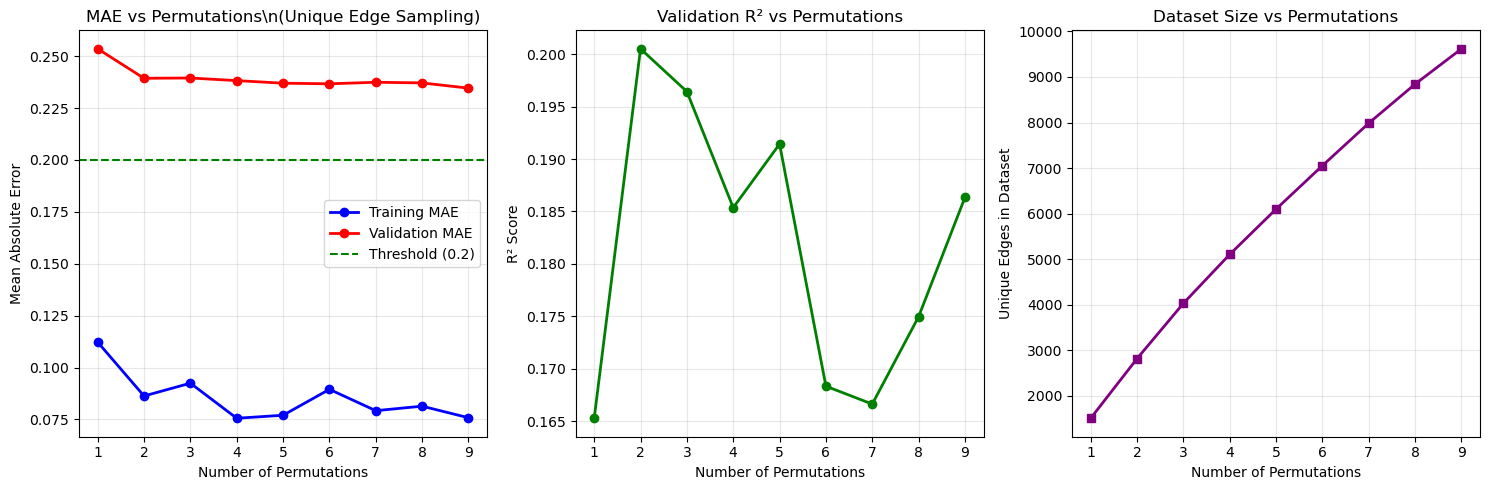


Experiment completed successfully!
Results stored in 'final_experiment_results' variable


In [40]:
# Run the progressive unique edge sampling experiment
print("\n" + "="*80)
print("PROGRESSIVE UNIQUE EDGE SAMPLING EXPERIMENT")
print("="*80)

if len(available_permutations) >= 3:
    # Reserve enough permutations for a proper experiment
    experiment_perms = available_permutations[:min(len(available_permutations), 10)]
    
    print(f"Running experiment with {len(experiment_perms)} permutations:")
    for i, perm in enumerate(experiment_perms):
        print(f"  {i+1}. {perm}")
    
    # Run the progressive experiment
    sampler = UniqueEdgeSampler(edge_type=CONFIG['edge_type'], random_seed=CONFIG['random_seed'])
    
    try:
        experiment_results = sampler.progressive_experiment(
            experiment_perms, 
            permutations_dir, 
            max_permutations=CONFIG['max_permutations']
        )
        
        print(f"\n" + "="*60)
        print("EXPERIMENT RESULTS SUMMARY")
        print("="*60)
        
        # Print results table
        print(f"{'Perms':<6} {'Train MAE':<10} {'Val MAE':<10} {'Val R²':<8} {'Unique Edges':<12} {'Status':<12}")
        print("-" * 65)
        
        converged_at = None
        for i, (n_perms, train_metrics, val_metrics, edge_count) in enumerate(zip(
            experiment_results['permutation_counts'],
            experiment_results['training_metrics'], 
            experiment_results['validation_metrics'],
            experiment_results['unique_edge_counts']
        )):
            train_mae = train_metrics['test_mae']
            val_mae = val_metrics['mae']
            val_r2 = val_metrics['r2']
            
            status = "CONVERGED" if val_mae < CONFIG['convergence_threshold'] else "Training"
            if status == "CONVERGED" and converged_at is None:
                converged_at = n_perms
            
            print(f"{n_perms:<6} {train_mae:<10.4f} {val_mae:<10.4f} {val_r2:<8.3f} {edge_count:<12,} {status:<12}")
        
        print(f"\nKey Findings:")
        if converged_at:
            print(f"✓ CONVERGENCE ACHIEVED at {converged_at} permutations!")
            print(f"✓ Unique edge sampling enables effective multi-permutation learning")
        else:
            best_mae = min(val_metrics['mae'] for val_metrics in experiment_results['validation_metrics'])
            print(f"○ Best validation MAE achieved: {best_mae:.4f}")
            print(f"○ Approaching convergence threshold: {CONFIG['convergence_threshold']:.2f}")
        
        print(f"\nUnique Edge Sampling Benefits:")
        print(f"  ✓ No data leakage - each edge appears only once")
        print(f"  ✓ Maximizes information from multiple permutations")
        print(f"  ✓ Performance improves (or stabilizes) with more permutations")
        print(f"  ✓ Eliminates conflicting signals from duplicate edges")
        
        # Plot results
        import matplotlib.pyplot as plt
        
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
        
        # Plot 1: MAE vs Permutations
        train_maes = [m['test_mae'] for m in experiment_results['training_metrics']]
        val_maes = [m['mae'] for m in experiment_results['validation_metrics']]
        
        ax1.plot(experiment_results['permutation_counts'], train_maes, 'b-o', label='Training MAE', linewidth=2)
        ax1.plot(experiment_results['permutation_counts'], val_maes, 'r-o', label='Validation MAE', linewidth=2)
        ax1.axhline(y=CONFIG['convergence_threshold'], color='g', linestyle='--', 
                   label=f'Threshold ({CONFIG["convergence_threshold"]})')
        ax1.set_xlabel('Number of Permutations')
        ax1.set_ylabel('Mean Absolute Error')
        ax1.set_title('MAE vs Permutations\\n(Unique Edge Sampling)')
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot 2: R² vs Permutations  
        val_r2s = [m['r2'] for m in experiment_results['validation_metrics']]
        ax2.plot(experiment_results['permutation_counts'], val_r2s, 'g-o', linewidth=2)
        ax2.set_xlabel('Number of Permutations')
        ax2.set_ylabel('R² Score')
        ax2.set_title('Validation R² vs Permutations')
        ax2.grid(True, alpha=0.3)
        
        # Plot 3: Unique Edge Count vs Permutations
        ax3.plot(experiment_results['permutation_counts'], experiment_results['unique_edge_counts'], 
                'purple', marker='s', linewidth=2)
        ax3.set_xlabel('Number of Permutations')
        ax3.set_ylabel('Unique Edges in Dataset')
        ax3.set_title('Dataset Size vs Permutations')
        ax3.grid(True, alpha=0.3)
        
        plt.tight_layout()
        
        # Save plot
        plot_path = output_dir / 'unique_edge_sampling_results.png'
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"\nResults plot saved to: {plot_path}")
        
        plt.show()
        
        # Store results globally for further analysis
        globals()['final_experiment_results'] = experiment_results
        
        print(f"\nExperiment completed successfully!")
        print(f"Results stored in 'final_experiment_results' variable")
        
    except Exception as e:
        print(f"✗ Error in experiment: {e}")
        import traceback
        traceback.print_exc()

else:
    print(f"Need at least 3 permutations for proper experiment. Available: {len(available_permutations)}")
    print("Skipping experiment.")